In [1]:
import pandas as pd
from os.path import join, basename
from glob import glob
from scipy.stats import spearmanr
import numpy as np
from sklearn.metrics import mean_absolute_error
''''
hyperformer all
'''
PATIENT_GROUP_LOCATION_IN_FILENAME = -3
SUBKLINISCHE_GRUPPE = "Subklinische_Gruppe"
GROUP_BY_DATE = True
GROUP_SEPARATOR = "/"
ID_LOCATION_IN_FILENAME = -2
''''
    meta data and neutral texts 
'''
RESULTS_BASE = "/data/eihw-gpu2/pechleba/results/"
BASELINE_BASE = "/data/eihw-gpu2/pechleba/results/"
BASELINE_FOLDER = "new_hyperformer++_base"
RESULT_FOLDER = "hyperformer++_ema_depression_tests_embeddings_nt"
''''
hyperformer all
    neutral texts 
'''
#RESULTS_BASE = "/data/eihw-gpu1/pechleba/results"
#BASELINE_BASE = "/data/eihw-gpu2/pechleba/ParaSpeChaD/results/"
#BASELINE_FOLDER = "wav2vec"
#RESULT_FOLDER = "hyperformer++_all_nt"


''''
hyperformer reapprasials
'''
# PATIENT_GROUP_LOCATION_IN_FILENAME = -4
# SUBKLINISCHE_GRUPPE = "SubklinischeGruppe"
''''
    meta data 
'''
# RESULTS_BASE = "/data/eihw-gpu2/pechleba/results/"
# BASELINE_BASE = "/data/eihw-gpu2/pechleba/results/gpu1/"
# BASELINE_FOLDER = "hyperformer++_reapprasial"
# RESULT_FOLDER = "hyperformer++_reapprasial_meta_depression"
''''
hyperformer reapprasials
    neutral texts 
'''
#RESULTS_BASE = "/data/eihw-gpu1/pechleba/results"
#BASELINE_BASE = "/data/eihw-gpu1/pechleba/results"
#BASELINE_FOLDER = "hyperformer++_reapprasial"
#RESULT_FOLDER = "hyperformer++_reapprasial_nt"
''''
hyperformer reapprasials
    meta data and neutral texts 
'''
#RESULTS_BASE = "/data/eihw-gpu2/pechleba/results/"
#BASELINE_BASE = "/data/eihw-gpu1/pechleba/results"
#BASELINE_FOLDER = "hyperformer++_reapprasial"
#RESULT_FOLDER = "hyperformer++_reapprasial_meta_nt_many_hot"



"'\nhyperformer reapprasials\n    meta data and neutral texts \n"

In [2]:
def load_predictions(experiment, patient_groups=None, result_base_adjusted=None):
    predictions = {}
    if result_base_adjusted is None: 
        current_result_base = RESULTS_BASE 
    else: 
        current_result_base = result_base_adjusted
    fold_dirs = glob(f"{current_result_base}/{experiment}/*/")
    for fold_dir in fold_dirs:
        try:
            # fold = int(fold_dir.split("/")[-2])
            fold = int(fold_dir.split("/")[-2])
            fold_predictions = list(glob(f"{fold_dir}/*.csv"))[0]
            _predictions = parse_filename(pd.read_csv(fold_predictions))

            if patient_groups is not None:
                _predictions = _predictions[~_predictions['ID'].isin(['EC0563', 'UR0961', 'LK0568', 'MJ0167', 'HH0656'])]
                _predictions = _predictions[_predictions["patientGroup"].isin(patient_groups)]
            if not "true" in _predictions.columns:
                _predictions["true"] = _predictions["selfRatingDepression"]
            predictions[fold] = _predictions
        except ValueError:
            print(f"{fold_dir} probably not a fold directory.")
    all_predictions = pd.concat(predictions.values())
    return predictions, all_predictions

def parse_filename(df):    
    

    # df["patientGroup"] = df["filename"].apply(lambda x: x.split("/")[-3])
    # df["ID"] = df["filename"].apply(lambda x: x.split("/")[-2])

    if GROUP_BY_DATE:
      
        df["date"] = df["filename"].apply(lambda x: "_".join(basename(x).split("_")[:-2]))

        df["Content"] = df["filename"].apply(
            lambda x: "_".join(basename(x).split("_")[-2:])
        )
        df["Content"] = df["Content"].apply(lambda x: "Frage" if "Frage" in x else "Antwort" if "Antwort" in x else "positiverGedanke")
    df["patientGroup"] = df["filename"].apply(lambda x: x.split(GROUP_SEPARATOR)[PATIENT_GROUP_LOCATION_IN_FILENAME])

    df["patientGroup"] = df["patientGroup"].apply(lambda x: SUBKLINISCHE_GRUPPE if x in SUBKLINISCHE_GRUPPE else x)

    df["ID"] = df["filename"].apply(lambda x: x.split(GROUP_SEPARATOR)[ID_LOCATION_IN_FILENAME])#PATIENT_GROUP_LOCATION_IN_FILENAME + 1
    return df
    
def session_mean(df):
    
    return df.groupby(["ID", "date", "patientGroup"])[["true", "prediction"]].mean().reset_index()
    

def compute_metrics(df, group_by=[]):
    columns = ["ID", "prediction", "true"] + group_by
    speaker_spearman = df[["ID", "prediction", "true"]].groupby(["ID"]).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().mean()
    if group_by:
        grouped_speaker_spearman = df[columns].groupby(["ID"] + group_by).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().groupby(group_by).mean()
    return speaker_spearman, grouped_speaker_spearman


    
def compute_metrics_2(df, group_by=[]):
    columns = ["ID", "prediction", "true"] + group_by
    speaker_spearman = df[["ID", "prediction", "true"]].groupby(["ID"]).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().mean()
    mae = mean_absolute_error(df["true"], df["prediction"])
    
    if group_by:
        grouped_speaker_spearman = df[columns].groupby(["ID"] + group_by).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().groupby(group_by).mean()
        grouped_mae = df[columns].groupby(["ID"] + group_by).apply(lambda x: mean_absolute_error(x["true"], x["prediction"])).dropna().groupby(group_by).mean()
        return speaker_spearman, grouped_speaker_spearman, mae, grouped_mae
    else:
        return speaker_spearman, mae


In [3]:
predictions, all_predictions = load_predictions(BASELINE_FOLDER, result_base_adjusted=BASELINE_BASE)
all_predictions.to_csv(BASELINE_FOLDER + "_predictions.csv", index=False)

/data/eihw-gpu2/pechleba/results//new_hyperformer++_base/runs/ probably not a fold directory.


In [3]:
def print_metrics(metrics):
    metric_string = ""
    for key in sorted(metrics.keys()):
        metric_string += f" & {np.mean(metrics[key]):.3f} ({np.std(metrics[key]):.3f})"
    return metric_string + " \\\\"

def print_metrics_2(metrics, metrics_mae):
    metric_string = ""
    for key in sorted(metrics.keys()):
        metric_string += f" & {np.mean(metrics[key]):.3f}\(\pm\){np.std(metrics[key]):.3f} & {np.mean(metrics_mae[key]):.3f}\(\pm\){np.std(metrics_mae[key]):.3f}"
    return metric_string + " \\\\"

def general_metrics(experiment, result_base_adjusted=None):
    predictions_fold, predictions_all = load_predictions(experiment, result_base_adjusted=result_base_adjusted)
    metrics = {"All": [], "Kontrollgruppe": [], "PatientInnen": [], SUBKLINISCHE_GRUPPE: []}
    for predictions in predictions_fold.values():
        predictions_mean = session_mean(predictions)
        speaker_rho, grouped_speaker_rho = compute_metrics(predictions_mean, group_by=["patientGroup"])
        metrics["All"].append(speaker_rho)
        for name, value in zip(grouped_speaker_rho.index, grouped_speaker_rho.values):
            metrics[name].append(value)
    return metrics

def general_metrics_2(experiment, result_base_adjusted=None):
    predictions_fold, predictions_all = load_predictions(experiment, result_base_adjusted=result_base_adjusted)
    metrics = {"All": [], "Kontrollgruppe": [], "PatientInnen": [], SUBKLINISCHE_GRUPPE: []}
    metrics_mae = {"All": [], "Kontrollgruppe": [], "PatientInnen": [], SUBKLINISCHE_GRUPPE: []}
    for predictions in predictions_fold.values():
        predictions_mean = session_mean(predictions)
        speaker_rho, grouped_speaker_rho, mae, grouped_mae = compute_metrics_2(predictions_mean, group_by=["patientGroup"])
        metrics["All"].append(speaker_rho)
        metrics_mae["All"].append(mae)
        for name, value in zip(grouped_speaker_rho.index, grouped_speaker_rho.values):
            metrics[name].append(value)
        for name, value in zip(grouped_mae.index, grouped_mae.values):
            metrics_mae[name].append(value)
    return metrics, metrics_mae

def phrase_metrics(experiment, result_base_adjusted):
    predictions_fold, predictions_all = load_predictions(experiment, result_base_adjusted=result_base_adjusted)
    metrics = {"All": {}, "Kontrollgruppe": {}, "PatientInnen": {}, SUBKLINISCHE_GRUPPE: {}}
    for predictions in predictions_fold.values():
        for content in predictions.Content.unique():
            _predictions = predictions[predictions.Content == content]
            speaker_rho, grouped_speaker_rho = compute_metrics(_predictions, group_by=["patientGroup"])
            if not content in metrics["All"]:
                metrics["All"][content] = []
            metrics["All"][content].append(speaker_rho)
            for name, value in zip(grouped_speaker_rho.index, grouped_speaker_rho.values):
                if not content in metrics[name]:
                    metrics[name][content] = []
                metrics[name][content].append(value)
    for group in metrics:
        for content in metrics[group]:
            metrics[group][content] = f"{np.mean(metrics[group][content]):.3f} ({np.std(metrics[group][content]):.3f})"
    return metrics

def type_metrics(experiment, folder=None):
    predictions_fold, predictions_all = load_predictions(experiment=experiment, result_base_adjusted=folder)
    metrics = {"All": {}, "Kontrollgruppe": {}, "PatientInnen": {}, SUBKLINISCHE_GRUPPE: {}}
    for predictions in predictions_fold.values():
        predictions["Content"] = predictions["Content"].apply(lambda x: "Frage" if "Frage" in x else "Antwort" if "Antwort" in x else "positiverGedanke" if "positiverGedanke" in x else "Garbage")
        if GROUP_BY_DATE:
            numeric_columns = ["true", "prediction"] 
            predictions = predictions.groupby(["ID", "patientGroup", "Content", "date"])[numeric_columns].mean().reset_index()
            # predictions = predictions.groupby(["ID", "date", "patientGroup", "Content"]).mean().reset_index()
        else:
            predictions = predictions.groupby(["ID", "patientGroup", "Content"]).mean().reset_index()
        for content in predictions.Content.unique():
            _predictions = predictions[predictions.Content == content]
            speaker_rho, grouped_speaker_rho = compute_metrics(_predictions, group_by=["patientGroup"])
            if not content in metrics["All"]:
                metrics["All"][content] = []
            metrics["All"][content].append(speaker_rho)
            for name, value in zip(grouped_speaker_rho.index, grouped_speaker_rho.values):
                if not content in metrics[name]:
                    metrics[name][content] = []
                metrics[name][content].append(value)
    for group in metrics:
        for content in metrics[group]:
            metrics[group][content] = f"{np.mean(metrics[group][content]):.3f} ({np.std(metrics[group][content]):.3f})"
    return metrics
    

In [5]:
m = phrase_metrics(RESULT_FOLDER, RESULTS_BASE)
print(pd.DataFrame(data=m).to_latex())

/data/eihw-gpu2/pechleba/results//hyperformer++_ema_depression_tests_embeddings_nt/runs/ probably not a fold directory.


\begin{tabular}{lllll}
\toprule
{} &            All & Kontrollgruppe &   PatientInnen & Subklinische\_Gruppe \\
\midrule
Antwort          &  0.214 (0.044) &  0.165 (0.045) &  0.214 (0.090) &       0.249 (0.059) \\
Frage            &  0.135 (0.044) &  0.100 (0.041) &  0.153 (0.095) &       0.144 (0.067) \\
positiverGedanke &  0.123 (0.032) &  0.093 (0.011) &  0.119 (0.084) &       0.142 (0.020) \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3074787/3478838223.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(data=m).to_latex())


In [4]:
import warnings
from scipy.stats import ConstantInputWarning
warnings.filterwarnings('ignore', category=ConstantInputWarning)
warnings.filterwarnings('ignore', category=UserWarning, module='scipy')
configs = [
    ("Baseline", "wav2vec", "/data/eihw-gpu2/pechleba/results/"),
    ("Embed", "hyperformer++_meta_embeddings", "/data/eihw-gpu2/pechleba/results/"),
    ("Tests", "hyperformer++_all", "/data/eihw-gpu2/pechleba/results/gpu1/"),
    ("NT", "hyperformer++_all_nt", "/data/eihw-gpu2/pechleba/results/gpu1/"),
    ("Tests&Embed", "hyperformer++_meta_depression_tests_embeddings", "/data/eihw-gpu2/pechleba/results/"),
    ("Tests&NT", "hyperformer++_all_meta_nt", "/data/eihw-gpu2/pechleba/results/gpu1/"),
    ("Tests&Embed&NT", "hyperformer++_meta_depression_tests_embeddings_nt", "/data/eihw-gpu2/pechleba/results/"),

]

for name, folder, base in configs:
    print(name)

    m = type_metrics(experiment=folder, folder=base)
    print(pd.DataFrame(data=m).to_latex())


Baseline


/tmp/ipykernel_770059/1468234699.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  speaker_spearman = df[["ID", "prediction", "true"]].groupby(["ID"]).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().mean()
/tmp/ipykernel_770059/1468234699.py:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_speaker_spearman = df[columns].groupby(["ID"] + group_by).apply(lambda x: spearmanr(x["p

\begin{tabular}{lllll}
\toprule
 & All & Kontrollgruppe & PatientInnen & Subklinische_Gruppe \\
\midrule
Antwort & 0.360 (0.093) & 0.276 (0.142) & 0.399 (0.091) & 0.384 (0.092) \\
Frage & 0.165 (0.041) & 0.078 (0.022) & 0.181 (0.082) & 0.193 (0.124) \\
positiverGedanke & 0.168 (0.071) & 0.137 (0.078) & 0.185 (0.093) & 0.187 (0.071) \\
\bottomrule
\end{tabular}

Embed
/data/eihw-gpu2/pechleba/results//hyperformer++_meta_embeddings/runs/ probably not a fold directory.


/tmp/ipykernel_770059/1468234699.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  speaker_spearman = df[["ID", "prediction", "true"]].groupby(["ID"]).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().mean()
/tmp/ipykernel_770059/1468234699.py:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_speaker_spearman = df[columns].groupby(["ID"] + group_by).apply(lambda x: spearmanr(x["p

\begin{tabular}{lllll}
\toprule
 & All & Kontrollgruppe & PatientInnen & Subklinische_Gruppe \\
\midrule
Antwort & 0.462 (0.029) & 0.399 (0.057) & 0.489 (0.068) & 0.488 (0.069) \\
Frage & 0.213 (0.041) & 0.145 (0.066) & 0.252 (0.107) & 0.214 (0.078) \\
positiverGedanke & 0.232 (0.029) & 0.198 (0.077) & 0.272 (0.055) & 0.227 (0.027) \\
\bottomrule
\end{tabular}

Tests
/data/eihw-gpu2/pechleba/results/gpu1//hyperformer++_all/runs/ probably not a fold directory.


/tmp/ipykernel_770059/1468234699.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  speaker_spearman = df[["ID", "prediction", "true"]].groupby(["ID"]).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().mean()
/tmp/ipykernel_770059/1468234699.py:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_speaker_spearman = df[columns].groupby(["ID"] + group_by).apply(lambda x: spearmanr(x["p

\begin{tabular}{lllll}
\toprule
 & All & Kontrollgruppe & PatientInnen & Subklinische_Gruppe \\
\midrule
Antwort & 0.442 (0.030) & 0.370 (0.064) & 0.493 (0.065) & 0.455 (0.071) \\
Frage & 0.192 (0.034) & 0.140 (0.060) & 0.234 (0.075) & 0.190 (0.050) \\
positiverGedanke & 0.228 (0.036) & 0.200 (0.049) & 0.278 (0.038) & 0.199 (0.050) \\
\bottomrule
\end{tabular}

NT
/data/eihw-gpu2/pechleba/results/gpu1//hyperformer++_all_nt/runs/ probably not a fold directory.


/tmp/ipykernel_770059/1468234699.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  speaker_spearman = df[["ID", "prediction", "true"]].groupby(["ID"]).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().mean()
/tmp/ipykernel_770059/1468234699.py:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_speaker_spearman = df[columns].groupby(["ID"] + group_by).apply(lambda x: spearmanr(x["p

\begin{tabular}{lllll}
\toprule
 & All & Kontrollgruppe & PatientInnen & Subklinische_Gruppe \\
\midrule
Antwort & 0.436 (0.040) & 0.390 (0.064) & 0.464 (0.062) & 0.445 (0.087) \\
Frage & 0.192 (0.055) & 0.112 (0.055) & 0.213 (0.107) & 0.218 (0.124) \\
positiverGedanke & 0.219 (0.042) & 0.192 (0.091) & 0.261 (0.047) & 0.212 (0.064) \\
\bottomrule
\end{tabular}

Tests&Embed
/data/eihw-gpu2/pechleba/results//hyperformer++_meta_depression_tests_embeddings/runs/ probably not a fold directory.


/tmp/ipykernel_770059/1468234699.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  speaker_spearman = df[["ID", "prediction", "true"]].groupby(["ID"]).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().mean()
/tmp/ipykernel_770059/1468234699.py:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_speaker_spearman = df[columns].groupby(["ID"] + group_by).apply(lambda x: spearmanr(x["p

\begin{tabular}{lllll}
\toprule
 & All & Kontrollgruppe & PatientInnen & Subklinische_Gruppe \\
\midrule
Antwort & 0.476 (0.032) & 0.417 (0.065) & 0.516 (0.056) & 0.486 (0.076) \\
Frage & 0.219 (0.037) & 0.142 (0.052) & 0.259 (0.102) & 0.220 (0.070) \\
positiverGedanke & 0.228 (0.038) & 0.210 (0.094) & 0.265 (0.041) & 0.218 (0.045) \\
\bottomrule
\end{tabular}

Tests&NT
/data/eihw-gpu2/pechleba/results/gpu1//hyperformer++_all_meta_nt/runs/ probably not a fold directory.


/tmp/ipykernel_770059/1468234699.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  speaker_spearman = df[["ID", "prediction", "true"]].groupby(["ID"]).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().mean()
/tmp/ipykernel_770059/1468234699.py:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_speaker_spearman = df[columns].groupby(["ID"] + group_by).apply(lambda x: spearmanr(x["p

\begin{tabular}{lllll}
\toprule
 & All & Kontrollgruppe & PatientInnen & Subklinische_Gruppe \\
\midrule
Antwort & 0.437 (0.040) & 0.380 (0.065) & 0.472 (0.047) & 0.448 (0.084) \\
Frage & 0.196 (0.057) & 0.114 (0.066) & 0.210 (0.104) & 0.226 (0.106) \\
positiverGedanke & 0.224 (0.042) & 0.205 (0.095) & 0.252 (0.058) & 0.224 (0.059) \\
\bottomrule
\end{tabular}

Tests&Embed&NT
/data/eihw-gpu2/pechleba/results//hyperformer++_meta_depression_tests_embeddings_nt/runs/ probably not a fold directory.


/tmp/ipykernel_770059/1468234699.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  speaker_spearman = df[["ID", "prediction", "true"]].groupby(["ID"]).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().mean()
/tmp/ipykernel_770059/1468234699.py:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_speaker_spearman = df[columns].groupby(["ID"] + group_by).apply(lambda x: spearmanr(x["p

\begin{tabular}{lllll}
\toprule
 & All & Kontrollgruppe & PatientInnen & Subklinische_Gruppe \\
\midrule
Antwort & 0.463 (0.026) & 0.415 (0.071) & 0.510 (0.064) & 0.460 (0.080) \\
Frage & 0.209 (0.048) & 0.160 (0.088) & 0.238 (0.107) & 0.209 (0.063) \\
positiverGedanke & 0.228 (0.043) & 0.215 (0.110) & 0.273 (0.034) & 0.204 (0.025) \\
\bottomrule
\end{tabular}



/tmp/ipykernel_770059/1468234699.py:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_speaker_spearman = df[columns].groupby(["ID"] + group_by).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().groupby(group_by).mean()
/tmp/ipykernel_770059/1468234699.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  speaker_spearman = df[["ID", "prediction", "true"]].groupby(["ID"]).apply(lambda

In [8]:
predictions = list(glob(join(RESULTS_BASE, RESULT_FOLDER, "**/*.csv")))
predictions_df = pd.concat([pd.read_csv(csv) for csv in predictions])
predictions_df.to_csv("predictions_"+RESULT_FOLDER+"_hyperformer.csv", index=False)

/data/eihw-gpu2/pechleba/results//hyperformer++_meta_embeddings/runs/ probably not a fold directory.
/data/eihw-gpu2/pechleba/results/gpu1//hyperformer++_all/runs/ probably not a fold directory.
/data/eihw-gpu2/pechleba/results/gpu1//hyperformer++_all_nt/runs/ probably not a fold directory.
/data/eihw-gpu2/pechleba/results//hyperformer++_meta_depression_tests_embeddings/runs/ probably not a fold directory.
/data/eihw-gpu2/pechleba/results/gpu1//hyperformer++_all_meta_nt/runs/ probably not a fold directory.
/data/eihw-gpu2/pechleba/results//hyperformer++_meta_depression_tests_embeddings_nt/runs/ probably not a fold directory.
                                                filename  prediction  \
0      ./data/processed/EMA/Kontrollgruppe/PM0860/202...    1.082000   
1      ./data/processed/EMA/Kontrollgruppe/PM0860/202...    0.624000   
2      ./data/processed/EMA/Kontrollgruppe/PM0860/202...    0.825000   
3      ./data/processed/EMA/Kontrollgruppe/PM0860/202...    1.644000   
4      

/tmp/ipykernel_770059/675509255.py:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: spearmanr(x["prediction"], x["true"])[0])
/tmp/ipykernel_770059/675509255.py:66: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  predictions_hyperformer_avg = predictions_for_avg[
/tmp/ipykernel_770059/675509255.py:66: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  predictions_hyperformer_avg = predictions_for_avg[
/tmp/ipykernel_770059/675509255.py:66: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  predictions_hyperformer_avg = predictions_for_avg[
/tmp/ipykernel_770059/675509255.py:66: UserWarning: Boole

Embed
_____________________________
set()
0.3064094294381618 0.22755827811336146
0.4035568510028775 0.23239744450108574
Mean diff: 0.09714742156471576 (0.1684105540568111)
______________________________
Tests
_____________________________
set()
0.3064094294381618 0.22755827811336146
0.3768244496119941 0.22570683418947163
Mean diff: 0.07041502017383233 (0.17550589144046064)
______________________________
NT
_____________________________
set()
0.3064094294381618 0.22755827811336146
0.37141688683743235 0.23566219754538828
Mean diff: 0.06500745739927055 (0.1454196420987902)
______________________________
Tests&Embed
_____________________________
set()
0.3064094294381618 0.22755827811336146
0.4160273343731881 0.23593525713686264
Mean diff: 0.10961790493502634 (0.1727657667861901)
______________________________
Tests&NT
_____________________________
set()
0.3064094294381618 0.22755827811336146
0.37377473084406876 0.23379297435508256
Mean diff: 0.067365301405907 (0.1479591032644137)
_________

/data/eihw-gpu1/pechleba/SpeechFormer/.devenv/state/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/eihw-gpu1/pechleba/SpeechFormer/.devenv/state/venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/data/eihw-gpu1/pechleba/SpeechFormer/.devenv/state/venv/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/eihw-gpu1/pechleba/SpeechFormer/.devenv/state/venv/lib/python3.10/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/data/eihw-gpu1/pechleba/SpeechFormer/.devenv/state/venv/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid va

nan nan


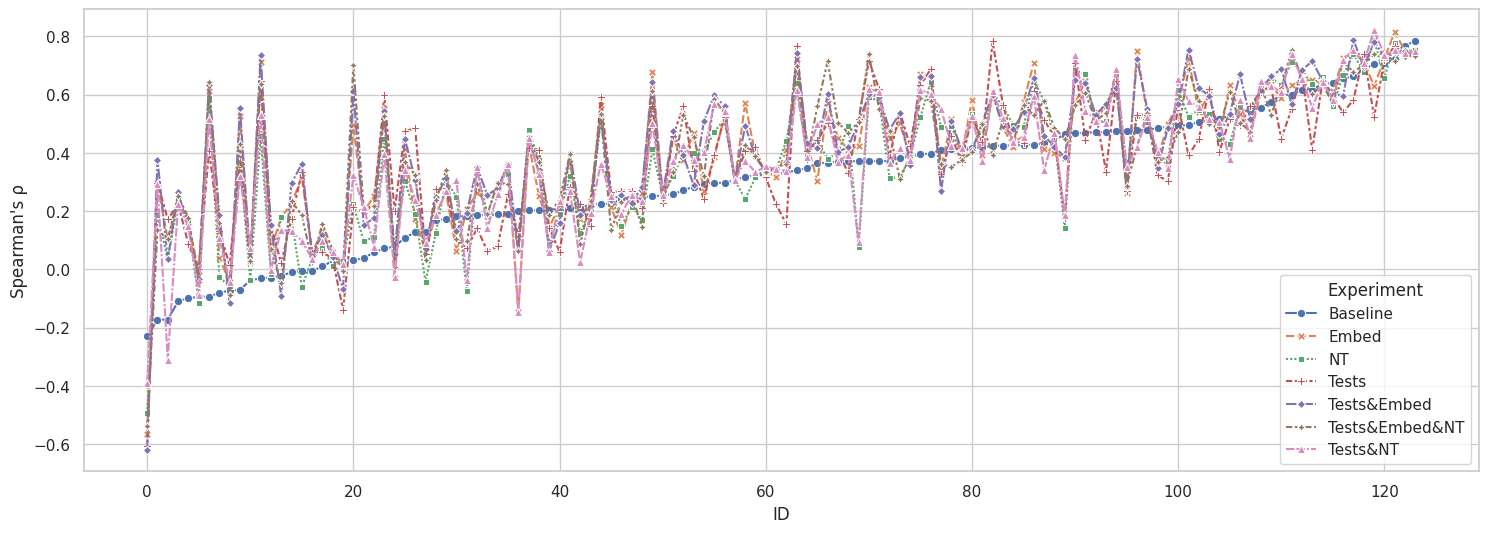

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

groups = ["Kontrollgruppe", SUBKLINISCHE_GRUPPE, "PatientInnen" ]
configs = [
    ("Baseline", "wav2vec", "/data/eihw-gpu2/pechleba/results/"),
    ("Embed", "hyperformer++_meta_embeddings", "/data/eihw-gpu2/pechleba/results/"),
    ("Tests", "hyperformer++_all", "/data/eihw-gpu2/pechleba/results/gpu1/"),
    ("NT", "hyperformer++_all_nt", "/data/eihw-gpu2/pechleba/results/gpu1/"),
    ("Tests&Embed", "hyperformer++_meta_depression_tests_embeddings", "/data/eihw-gpu2/pechleba/results/"),
    ("Tests&NT", "hyperformer++_all_meta_nt", "/data/eihw-gpu2/pechleba/results/gpu1/"),
    ("Tests&Embed&NT", "hyperformer++_meta_depression_tests_embeddings_nt", "/data/eihw-gpu2/pechleba/results/"),
]

predictions_list = []
for name, path, result_base_adjusted in configs:
    _, predictions = load_predictions(path, patient_groups=groups, result_base_adjusted=result_base_adjusted)

    predictions["Experiment"] = name
    predictions_list.append(predictions)

predictions = pd.concat(predictions_list)

predictions = predictions[predictions.patientGroup.isin(groups)]
print(predictions)
if GROUP_BY_DATE:
    num_values = ["true", "prediction"]
    predictions = (
        predictions.groupby(["ID", "Experiment", "date", "patientGroup"])[num_values]
        .mean()
        .reset_index()
    )

    # predictions = (
    #     predictions.groupby(["ID", "Experiment", "date", "patientGroup"])
    #     .mean()
    #     .reset_index()
    # )

predictions = (
    predictions[["ID", "Experiment", "prediction", "true"]]
    .groupby(["ID", "Experiment"])
    .apply(lambda x: spearmanr(x["prediction"], x["true"])[0])
    .sort_values()
    .sort_index(level="Experiment", sort_remaining=False)
    .reset_index()
)

    
predictions_for_avg = predictions

predictions_for_avg.columns = ["ID", "Experiment", "Spearman's ρ"]
nan_rows = predictions_for_avg[predictions_for_avg["Spearman's ρ"].isna()]

predictions_for_avg = predictions_for_avg[~predictions_for_avg.index.isin(nan_rows.index)]

predictions_baseline_avg_ = predictions_for_avg[
    predictions_for_avg.Experiment == "Baseline"].sort_values(
    by="ID"
)

for name, path, result_base_adjusted in configs:
    if name != "Baseline":
        print(name)
        print("_____________________________")
        predictions_hyperformer_avg = predictions_for_avg[
            predictions.Experiment == name
        ].sort_values(by="ID")
        print(set(predictions_baseline_avg_["ID"]) - set(predictions_hyperformer_avg["ID"]))
        common_indices = predictions_baseline_avg_.index[predictions_baseline_avg_["ID"].isin(predictions_hyperformer_avg["ID"])]
        predictions_baseline_avg = predictions_baseline_avg_
        predictions_baseline_avg = predictions_baseline_avg.loc[common_indices]
        print(np.mean(predictions_baseline_avg["Spearman\'s ρ"].values), np.std(predictions_baseline_avg["Spearman\'s ρ"].values))
        print(np.mean(predictions_hyperformer_avg["Spearman\'s ρ"].values), np.std(predictions_hyperformer_avg["Spearman\'s ρ"].values))

        help = predictions_baseline_avg["Spearman's ρ"].values

        predictions_baseline_avg["Diff"] = (
            predictions_hyperformer_avg["Spearman's ρ"].values
            - help
        )

        print(
            f"Mean diff: {predictions_baseline_avg['Diff'].mean()} ({np.std(predictions_baseline_avg['Diff'])})"
        )
        print("______________________________")

# print((predictions["ID"].values))
print(len(set(predictions["ID"].values)))
predictions["ID"] = pd.factorize(predictions["ID"].values, sort=False)[0]

predictions_hyperformer = predictions[
    predictions.Experiment == "SpeechFormer++ Base"
].sort_values(by="ID")

predictions.columns = ["ID", "Experiment", "Spearman's ρ"]
predictions_baseline = predictions[predictions.Experiment == "Baseline"].sort_values(
    by="ID"
)

predictions_hyperformer = predictions[
    predictions.Experiment == "SpeechFormer++ adapter"
].sort_values(by="ID")



predictions_hyperformer.sort_values(by="Spearman's ρ").to_csv("name.csv", index=False)
sns.set_theme(style="whitegrid", rc={"figure.figsize": (18, 6)})
sns.lineplot(
    data=predictions,
    x="ID",
    y="Spearman's ρ",
    hue="Experiment",
    style="Experiment",
    markers=True,
)
predictions_hyperformer.columns = ["ID", "Experiment", "Spearman's ρ"]

nan_rows = predictions_hyperformer[predictions_hyperformer["Spearman's ρ"].isna()]

predictions_hyperformer = predictions_hyperformer[~predictions_hyperformer.index.isin(nan_rows.index)]

print(np.mean(predictions_hyperformer["Spearman\'s ρ"].values), np.std(predictions_hyperformer["Spearman\'s ρ"].values))


plt.savefig(f"speaker_performance_{RESULT_FOLDER.split('/')[-1]}_{'_'.join(groups)}.pdf")


In [8]:
table_contents = []
for name, path, result_base_adjusted in configs:
    m, mae = general_metrics_2(path, result_base_adjusted=result_base_adjusted)

    table_contents.append(f"{name} {print_metrics_2(m, mae)}")
print("\n".join(table_contents))


/tmp/ipykernel_92187/1468234699.py:63: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  speaker_spearman = df[["ID", "prediction", "true"]].groupby(["ID"]).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().mean()
/tmp/ipykernel_92187/1468234699.py:67: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_speaker_spearman = df[columns].groupby(["ID"] + group_by).apply(lambda x: spearmanr(x["pre

/data/eihw-gpu2/pechleba/results//hyperformer++_meta_embeddings/runs/ probably not a fold directory.


/tmp/ipykernel_92187/1468234699.py:63: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  speaker_spearman = df[["ID", "prediction", "true"]].groupby(["ID"]).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().mean()
/tmp/ipykernel_92187/1468234699.py:67: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_speaker_spearman = df[columns].groupby(["ID"] + group_by).apply(lambda x: spearmanr(x["pre

/data/eihw-gpu2/pechleba/results/gpu1//hyperformer++_all/runs/ probably not a fold directory.


/tmp/ipykernel_92187/1468234699.py:63: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  speaker_spearman = df[["ID", "prediction", "true"]].groupby(["ID"]).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().mean()
/tmp/ipykernel_92187/1468234699.py:67: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_speaker_spearman = df[columns].groupby(["ID"] + group_by).apply(lambda x: spearmanr(x["pre

/data/eihw-gpu2/pechleba/results/gpu1//hyperformer++_all_nt/runs/ probably not a fold directory.


/tmp/ipykernel_92187/1468234699.py:63: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  speaker_spearman = df[["ID", "prediction", "true"]].groupby(["ID"]).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().mean()
/tmp/ipykernel_92187/1468234699.py:67: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_speaker_spearman = df[columns].groupby(["ID"] + group_by).apply(lambda x: spearmanr(x["pre

/data/eihw-gpu2/pechleba/results//hyperformer++_meta_depression_tests_embeddings/runs/ probably not a fold directory.


/tmp/ipykernel_92187/1468234699.py:63: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  speaker_spearman = df[["ID", "prediction", "true"]].groupby(["ID"]).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().mean()
/tmp/ipykernel_92187/1468234699.py:67: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_speaker_spearman = df[columns].groupby(["ID"] + group_by).apply(lambda x: spearmanr(x["pre

/data/eihw-gpu2/pechleba/results/gpu1//hyperformer++_all_meta_nt/runs/ probably not a fold directory.


/tmp/ipykernel_92187/1468234699.py:63: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  speaker_spearman = df[["ID", "prediction", "true"]].groupby(["ID"]).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().mean()
/tmp/ipykernel_92187/1468234699.py:67: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_speaker_spearman = df[columns].groupby(["ID"] + group_by).apply(lambda x: spearmanr(x["pre

/data/eihw-gpu2/pechleba/results//hyperformer++_meta_depression_tests_embeddings_nt/runs/ probably not a fold directory.


/tmp/ipykernel_92187/1468234699.py:63: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  speaker_spearman = df[["ID", "prediction", "true"]].groupby(["ID"]).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().mean()
/tmp/ipykernel_92187/1468234699.py:67: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_speaker_spearman = df[columns].groupby(["ID"] + group_by).apply(lambda x: spearmanr(x["pre

Baseline  & 0.304\(\pm\)0.079 & 1.747\(\pm\)0.189 & 0.231\(\pm\)0.093 & 1.149\(\pm\)0.216 & 0.339\(\pm\)0.079 & 2.629\(\pm\)0.345 & 0.325\(\pm\)0.116 & 1.426\(\pm\)0.268 \\
Embed  & 0.404\(\pm\)0.032 & 1.646\(\pm\)0.215 & 0.357\(\pm\)0.074 & 0.861\(\pm\)0.137 & 0.429\(\pm\)0.072 & 2.697\(\pm\)0.362 & 0.418\(\pm\)0.063 & 1.289\(\pm\)0.254 \\
Tests  & 0.377\(\pm\)0.043 & 1.181\(\pm\)0.192 & 0.319\(\pm\)0.067 & 0.407\(\pm\)0.074 & 0.436\(\pm\)0.058 & 2.124\(\pm\)0.315 & 0.370\(\pm\)0.061 & 1.028\(\pm\)0.121 \\
NT  & 0.371\(\pm\)0.052 & 1.608\(\pm\)0.231 & 0.322\(\pm\)0.074 & 0.838\(\pm\)0.168 & 0.403\(\pm\)0.068 & 2.694\(\pm\)0.482 & 0.381\(\pm\)0.100 & 1.239\(\pm\)0.202 \\
Tests&Embed  & 0.417\(\pm\)0.034 & 1.463\(\pm\)0.172 & 0.374\(\pm\)0.081 & 0.714\(\pm\)0.150 & 0.445\(\pm\)0.064 & 2.488\(\pm\)0.340 & 0.427\(\pm\)0.072 & 1.124\(\pm\)0.206 \\
Tests&NT  & 0.374\(\pm\)0.055 & 1.592\(\pm\)0.231 & 0.321\(\pm\)0.085 & 0.787\(\pm\)0.139 & 0.404\(\pm\)0.067 & 2.728\(\pm\)0.399 & 0.392\(\pm\)

/tmp/ipykernel_92187/1468234699.py:68: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_mae = df[columns].groupby(["ID"] + group_by).apply(lambda x: mean_absolute_error(x["true"], x["prediction"])).dropna().groupby(group_by).mean()
/tmp/ipykernel_92187/1468234699.py:63: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  speaker_spearman = df[["ID", "prediction", "true"]].groupby(["ID"]).apply(lambda x: spea

In [8]:
from sklearn.metrics import mean_squared_error
from itertools import combinations
import numpy as np
import warnings
from scipy.stats import ConstantInputWarning
warnings.filterwarnings('ignore', category=ConstantInputWarning)
warnings.filterwarnings('ignore', category=UserWarning, module='scipy')
from scipy.interpolate import interp1d

# def gini(x):
#     # Mean absolute difference
#     
#     mad = np.abs(np.subtract.outer(x, x)).mean()
#     # Relative mean absolute difference
#     rmad = mad/np.mean(x)
#     # Gini coefficient
#     g = 0.5 * rmad
#     return g

def gini(x):
    """Compute Gini coefficient of array of values"""
    diffsum = 0
    x = np.array([float(value) for value in x["Spearman"].values])
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    result = diffsum / (len(x)**2 * np.mean(x))
    return result.tolist()

def gini_2(v, n_new = 1000):
    """Compute Gini coefficient of array of values"""
    v = [float(value) for value in v["Spearman"].values]
    v = (v - np.min(v)) / (np.max(v) - np.min(v))
    v_abs = np.sort(np.abs(v))
    cumsum_v = np.cumsum(v_abs)
    n = len(v_abs)
    vals = np.concatenate([[0], cumsum_v/cumsum_v[-1]])
    x = np.linspace(0, 1, n+1)
    f = interp1d(x=x, y=vals, kind='previous')
    xnew = np.linspace(0, 1, n_new+1)
    dx_new = 1/(n_new)
    vals_new = f(xnew)
    return 1 - 2 * np.trapz(y=vals_new, x=xnew, dx=dx_new)


def calc_gini_index(rmse_values):
    # Sort the rmse_values
    
    rmse_values["Spearman"] = ( rmse_values["Spearman"] - np.min( rmse_values["Spearman"])) / (np.max( rmse_values["Spearman"]) - np.min( rmse_values["Spearman"]))
    rmse_value_help = [float(value) if value > 0 else 0 for value in rmse_values["Spearman"].values]
    numeric_rmse_values =  sorted(rmse_value_help)

    # Calculate the cumulative sums
    cum_values = np.cumsum(numeric_rmse_values)
    sum_values = cum_values[-1]
    cum_indices = np.cumsum(np.arange(1, len(rmse_values) + 1))

    # Calculate the area under the line of perfect equality
    area_equal = np.trapz(cum_indices, dx=1)

    # Calculate the area under the Lorenz curve
    area_lorenz = np.trapz(cum_values, dx=1)

    # Calculate the Gini index
    gini_index = (area_equal - area_lorenz) / area_equal

    return gini_index


def calc_improvements(baseline, new_predictions, offset=1e-6):
    diff = new_predictions["Spearman"].values.squeeze() - baseline["Spearman"].values.squeeze()
    baseline = baseline["Spearman"].values.squeeze()

    improved = diff > 0
    got_worse = diff < 0

    num_improved = np.sum(improved)
    num_got_worse = np.sum(got_worse)

    median_improvement = np.median(diff[improved] / (np.abs(baseline[improved]) + offset))
    median_loss = np.median(diff[got_worse] / (np.abs(baseline[got_worse]) + offset))
    median_improvement_percent = round((1 + median_improvement) * 100, 2)
    median_loss_percent = round(-median_loss * 100, 2)

    return num_improved.tolist(), num_got_worse.tolist(), median_improvement_percent, median_loss_percent
    
    
predictions_list = []
predictions_base =[]
predictions_adapters = {}


for name, path, result_base_adjusted in configs:

    # if name == "SpeechFormer++ Base":
    #     _, predictions_base = load_predictions(path, result_base_adjusted=result_base_adjusted, patient_groups=["PatientInnen"])
    #     predictions_base = predictions_base[["ID", "true", "prediction"]]
    #     # rmse = predictions_base.groupby('ID').apply(lambda group: np.sqrt(mean_squared_error(group['true'], group['prediction'])))
    #     rmse = predictions_base.groupby('ID').apply(lambda group: mean_squared_error(group['true'], group['prediction']))
    #     predictions_base= rmse

    _, predictions_adapters[name] = load_predictions(path, result_base_adjusted=result_base_adjusted, patient_groups=["PatientInnen"])
    # # predictions_adapters[name] = predictions_adapters[name][["ID", "true", "prediction"]]
    # # rmse = predictions_adapters[name].groupby('ID').apply(lambda group: mean_squared_error(group['true'], group['prediction']))
    # # predictions_adapters[name]= rmse

    # predictions_adapters[name] = predictions_adapters[name][(predictions_adapters[name]["patientGroup"].isin(["Patienten"]))]

    # predictions_adapters[name] = general_metrics(experiment=path, result_base_adjusted=result_base_adjusted)

    # SPEARMAN

    
    num_values = ["true", "prediction"]

    predictions_adapters[name] = (
       predictions_adapters[name].groupby(["ID", "date", "patientGroup"])[num_values]
        .mean()
        .reset_index()
    )
    
    predictions_adapters[name] = (
        predictions_adapters[name][["ID", "prediction", "true"]]
        .groupby(["ID"])
        .apply(lambda x: spearmanr(x["prediction"], x["true"])[0])
        .sort_values()
        .sort_index(level="Experiment", sort_remaining=False)
        .reset_index()
    )

# predictions_base =  pd.DataFrame(predictions_base)
# predictions_adapters =  pd.DataFrame(predictions_adapters)

gini_index = {}
gini_winners_amount = {}
gini_winners_percent = {}
gini_losers_amount = {}
gini_losers_percent = {}

# Calculate the baseline Gini index
# predictions_base.columns = ["rmse"]
predictions_help = pd.DataFrame.from_dict(predictions_adapters["Baseline"])
# predictions_help.columns = [["rmse"]]
predictions_help.columns = [["ID", "Spearman"]]
predictions_baseline = predictions_help
# print(predictions_help)
baseline_gini_index= gini(predictions_help)
# print(f"Model: baseline\nGini Index: {gini_index['baseline']}")
for key in predictions_adapters.keys():
   
    predictions_help = pd.DataFrame.from_dict(predictions_adapters[key])
    # predictions_help.columns = [["rmse"]]
    # SPEARMAN
    predictions_help.columns = [["ID", "Spearman"]]
    
    # print(predictions_help)
    gini_index[key] = gini(predictions_help)
    # gini_index[key] = calc_gini_index(predictions_help)
    # gini_index[key] = gini_2(predictions_help)
    gini_winners_amount[key], gini_losers_amount[key],gini_winners_percent[key], gini_losers_percent[key] = calc_improvements(predictions_baseline, predictions_help)

    # Calculate the Gini coefficient relative to the baseline
    # gini_index[key] /= baseline_gini_index

    # print(f"Model: {key} Gini Index: {gini_index[key]}")
    # print(f"Model: {key} Winners Amount: {gini_winners_amount[key]}\nWinners Percent: {gini_winners_percent[key]}\nLosers Amount: {gini_losers_amount[key]}\nLosers Percent: {gini_losers_percent[key]}\n")


data = {
    "Model": list(gini_index.keys()),
    "Winners Amount": list(gini_winners_amount.values()),
    "Winners Percent": list(gini_winners_percent.values()),
    "Losers Amount": list(gini_losers_amount.values()),
    "Losers Percent": list(gini_losers_percent.values())
}

# Create DataFrame
df = pd.DataFrame(data)

df.fillna('--', inplace=True)

# Convert DataFrame to LaTeX table
latex_table = df.to_latex(index=False)

print(latex_table)

/tmp/ipykernel_770059/3624226745.py:124: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: spearmanr(x["prediction"], x["true"])[0])


/data/eihw-gpu2/pechleba/results//hyperformer++_meta_embeddings/runs/ probably not a fold directory.


/tmp/ipykernel_770059/3624226745.py:124: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: spearmanr(x["prediction"], x["true"])[0])


/data/eihw-gpu2/pechleba/results/gpu1//hyperformer++_all/runs/ probably not a fold directory.
/data/eihw-gpu2/pechleba/results/gpu1//hyperformer++_all_nt/runs/ probably not a fold directory.


/tmp/ipykernel_770059/3624226745.py:124: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: spearmanr(x["prediction"], x["true"])[0])
/tmp/ipykernel_770059/3624226745.py:124: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: spearmanr(x["prediction"], x["true"])[0])


/data/eihw-gpu2/pechleba/results//hyperformer++_meta_depression_tests_embeddings/runs/ probably not a fold directory.


/tmp/ipykernel_770059/3624226745.py:124: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: spearmanr(x["prediction"], x["true"])[0])


/data/eihw-gpu2/pechleba/results/gpu1//hyperformer++_all_meta_nt/runs/ probably not a fold directory.


/tmp/ipykernel_770059/3624226745.py:124: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: spearmanr(x["prediction"], x["true"])[0])


/data/eihw-gpu2/pechleba/results//hyperformer++_meta_depression_tests_embeddings_nt/runs/ probably not a fold directory.
\begin{tabular}{lrlrl}
\toprule
Model & Winners Amount & Winners Percent & Losers Amount & Losers Percent \\
\midrule
Baseline & 0 & -- & 0 & -- \\
Embed & 33 & 142.730000 & 12 & 11.220000 \\
Tests & 36 & 149.300000 & 9 & 21.600000 \\
NT & 32 & 133.250000 & 13 & 14.870000 \\
Tests&Embed & 35 & 144.210000 & 10 & 8.060000 \\
Tests&NT & 34 & 140.160000 & 11 & 21.460000 \\
Tests&Embed&NT & 30 & 166.790000 & 15 & 10.700000 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_770059/3624226745.py:124: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: spearmanr(x["prediction"], x["true"])[0])
/data/eihw-gpu1/pechleba/SpeechFormer/.devenv/state/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/eihw-gpu1/pechleba/SpeechFormer/.devenv/state/venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_770059/3624226745.py:179: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future

In [54]:
sns.lmplot(data=long_df[(long_df.Experiment.isin(["Baseline", "Hyperformer All", "Hyperformer Reapprasial NT META", "Hyperformer Reapprasial META"])) & (long_df.group.isin([1,2]))], x="t1_HAMD17_ges", y="Spearman", hue="Experiment")

NameError: name 'long_df' is not defined

In [10]:

#df, metadata = pyreadstat.read_sav("/data/eihw-gpu2/pechleba/ParaSpeChaD/metadata/Alle_Daten_bis_t2.sav")
df = pd.read_csv("/data/eihw-gpu2/pechleba/ParaSpeChaD/metadata/fixed_merged_file.csv")

long_dfs = []
wide_df_2 = df.copy()
groups = ["Kontrollgruppe", SUBKLINISCHE_GRUPPE, "PatientInnen" ]
configs = [
    ("Baseline", "wav2vec", "/data/eihw-gpu2/pechleba/results/"),
    ("Embed", "hyperformer++_meta_embeddings", "/data/eihw-gpu2/pechleba/results/"),
    ("Tests", "hyperformer++_all", "/data/eihw-gpu2/pechleba/results/gpu1/"),
    ("NT", "hyperformer++_all_nt", "/data/eihw-gpu2/pechleba/results/gpu1/"),
    ("Tests&Embed", "hyperformer++_meta_depression_tests_embeddings", "/data/eihw-gpu2/pechleba/results/"),
    ("Tests&NT", "hyperformer++_all_meta_nt", "/data/eihw-gpu2/pechleba/results/gpu1/"),
    ("Tests&Embed&NT", "hyperformer++_meta_depression_tests_embeddings_nt", "/data/eihw-gpu2/pechleba/results/"),
]


for j, (name, path, result_base_adjusted) in enumerate(configs):
    # _, predictions_hyperformer = load_predictions(path, result_base_adjusted=result_base_adjusted)
    folded_predictions, _ = load_predictions(path, patient_groups=groups, result_base_adjusted=result_base_adjusted)

    num_values = ["true", "prediction"]
    for i, predictions_hyperformer in folded_predictions.items():
        predictions_hyperformer = (
            predictions_hyperformer.groupby(["ID", "date", "patientGroup"])[num_values]
            .mean()
            .reset_index()
        )
        predictions_hyperformer = predictions_hyperformer[["ID", "prediction", "true"]]
        predictions_hyperformer_long = predictions_hyperformer.copy()
        predictions_hyperformer_long["Experiment"] = name
        predictions_hyperformer_long["fold"] = i
        long_dfs.append(predictions_hyperformer_long)
        if j == 0:
            predictions_hyperformer_long = predictions_hyperformer_long.copy()
            predictions_hyperformer_long["Experiment"] = "Groundtruth"
            predictions_hyperformer_long["prediction"] = predictions_hyperformer_long["true"]
            long_dfs.append(predictions_hyperformer_long)

    # predictions_hyperformer[name] = predictions_hyperformer[0]
    # wide_df = pd.merge(predictions_hyperformer, wide_df, left_on="ID", right_on="Code")
long_df = pd.merge(pd.concat(long_dfs), df, left_on="ID", right_on="Code")
print(long_df.columns)




/data/eihw-gpu2/pechleba/results//hyperformer++_meta_embeddings/runs/ probably not a fold directory.
/data/eihw-gpu2/pechleba/results/gpu1//hyperformer++_all/runs/ probably not a fold directory.
/data/eihw-gpu2/pechleba/results/gpu1//hyperformer++_all_nt/runs/ probably not a fold directory.
/data/eihw-gpu2/pechleba/results//hyperformer++_meta_depression_tests_embeddings/runs/ probably not a fold directory.
/data/eihw-gpu2/pechleba/results/gpu1//hyperformer++_all_meta_nt/runs/ probably not a fold directory.
/data/eihw-gpu2/pechleba/results//hyperformer++_meta_depression_tests_embeddings_nt/runs/ probably not a fold directory.
Index(['ID', 'prediction', 'true', 'Experiment', 'fold', 'Code', 'group',
       't1_datum', 't1_state_01', 't1_state_02',
       ...
       'f3_median', 'f4_median', 'nsyll', 'npause', 'dur(s)',
       'phonationtime(s)', 'speechrate(nsyll / dur)',
       'articulation rate(nsyll / phonationtime)', 'ASD(speakingtime / nsyll)',
       'subject'],
      dtype='objec

In [11]:
from scipy.stats import pearsonr
correlations_dict = {"Experiment": [], "PHQ": [], "HRSD": [], "SEK": [], "Groundtruth": []}

columns_mapping = {
    "PHQ": "t1_phq_sum",
    "HRSD": "t1_HAMD17_ges",
    "SEK": "t1_sek_sum",
    "Groundtruth": "true"
}

def spearman(data):
    d = {}
    for name, column in columns_mapping.items():
        d[name] = spearmanr(data["prediction"].values, data[column].values)[0]
    return pd.Series(d)

def mean_std_string(d):
    metric = f"{np.mean(d.values):.3f}"[1:]
    std = f"{np.std(d.values):.3f}"[1:]
    return f"$ {metric} \pm {std} $"

correlations_table = long_df.fillna(long_df[["prediction", "t1_phq_sum", "t1_sek_sum", "t1_HAMD17_ges", "true"]].mean()).groupby(["Experiment", "fold"]).apply(spearman).groupby("Experiment").agg(mean_std_string)


for experiment in long_df["Experiment"].unique():
    
    _df = long_df[long_df.Experiment == experiment][["prediction", "t1_phq_sum", "t1_sek_sum", "t1_HAMD17_ges", "true"]]
    _df.fillna(_df.mean(), inplace=True)
    correlations_dict["Experiment"].append(experiment)
    correlations_dict["PHQ"].append(spearmanr(_df["prediction"].values, _df["t1_phq_sum"].values)[0])
    correlations_dict["HRSD"].append(spearmanr(_df["prediction"].values, _df["t1_HAMD17_ges"].values)[0])
    correlations_dict["SEK"].append(spearmanr(_df["prediction"].values, _df["t1_sek_sum"].values)[0])
    correlations_dict["Groundtruth"].append(spearmanr(_df["prediction"].values, _df["true"].values)[0])
_df = long_df[long_df.Experiment == "Baseline FFNN"]
_df.fillna(_df.mean(), inplace=True)
correlations_dict["Experiment"].append("Groundtruth")
correlations_dict["PHQ"].append(spearmanr(_df["true"].values, _df["t1_phq_sum"].values)[0])
correlations_dict["HRSD"].append(spearmanr(_df["true"].values, _df["t1_HAMD17_ges"].values)[0])
correlations_dict["SEK"].append(spearmanr(_df["true"].values, _df["t1_sek_sum"].values)[0])
correlations_dict["Groundtruth"].append(spearmanr(_df["true"].values, _df["true"].values)[0])

print(correlations_table.to_latex(float_format="$%.6f$", escape=False))


/tmp/ipykernel_92187/3720699700.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlations_table = long_df.fillna(long_df[["prediction", "t1_phq_sum", "t1_sek_sum", "t1_HAMD17_ges", "true"]].mean()).groupby(["Experiment", "fold"]).apply(spearman).groupby("Experiment").agg(mean_std_string)


\begin{tabular}{lllll}
\toprule
 & PHQ & HRSD & SEK & Groundtruth \\
Experiment &  &  &  &  \\
\midrule
Baseline & $ .238 \pm .089 $ & $ .206 \pm .104 $ & $ 0.282 \pm .110 $ & $ .285 \pm .073 $ \\
Embed & $ .318 \pm .094 $ & $ .272 \pm .076 $ & $ 0.292 \pm .051 $ & $ .348 \pm .039 $ \\
Groundtruth & $ .670 \pm .107 $ & $ .658 \pm .103 $ & $ 0.608 \pm .074 $ & $ .000 \pm .000 $ \\
NT & $ .293 \pm .085 $ & $ .253 \pm .078 $ & $ 0.296 \pm .081 $ & $ .351 \pm .063 $ \\
Tests & $ .714 \pm .124 $ & $ .714 \pm .096 $ & $ 0.654 \pm .108 $ & $ .684 \pm .095 $ \\
Tests&Embed & $ .511 \pm .130 $ & $ .456 \pm .130 $ & $ 0.472 \pm .104 $ & $ .523 \pm .082 $ \\
Tests&Embed&NT & $ .462 \pm .163 $ & $ .438 \pm .181 $ & $ 0.441 \pm .138 $ & $ .477 \pm .072 $ \\
Tests&NT & $ .324 \pm .075 $ & $ .273 \pm .092 $ & $ 0.316 \pm .070 $ & $ .375 \pm .028 $ \\
\bottomrule
\end{tabular}



/tmp/ipykernel_92187/3720699700.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df.fillna(_df.mean(), inplace=True)


In [9]:
from scipy.stats import pearsonr
correlations_dict = {"Experiment": [], "PHQ": [], "HRSD": [], "SEK": [], "Groundtruth": []}
for experiment in long_df["Experiment"].unique():
    _df = long_df[long_df.Experiment == experiment]
    _df.fillna(_df.mean(), inplace=True)
    correlations_dict["Experiment"].append(experiment)
    correlations_dict["PHQ"].append(spearmanr(_df["prediction"].values, _df["t1_phq_sum"].values)[0])
    correlations_dict["HRSD"].append(spearmanr(_df["prediction"].values, _df["t1_HAMD17_ges"].values)[0])
    correlations_dict["SEK"].append(spearmanr(_df["prediction"].values, _df["t1_sek_sum"].values)[0])
    correlations_dict["Groundtruth"].append(spearmanr(_df["prediction"].values, _df["true"].values)[0])
_df = long_df[long_df.Experiment == "Baseline FFNN"]
_df.fillna(_df.mean(), inplace=True)
correlations_dict["Experiment"].append("Groundtruth")
correlations_dict["PHQ"].append(spearmanr(_df["true"].values, _df["t1_phq_sum"].values)[0])
correlations_dict["HRSD"].append(spearmanr(_df["true"].values, _df["t1_HAMD17_ges"].values)[0])
correlations_dict["SEK"].append(spearmanr(_df["true"].values, _df["t1_sek_sum"].values)[0])
correlations_dict["Groundtruth"].append(spearmanr(_df["true"].values, _df["true"].values)[0])

print(pd.DataFrame(data=correlations_dict).set_index("Experiment").to_latex(float_format="$%.6f$", escape=False))


NameError: name 'long_df' is not defined

In [ ]:
columns_test = [         "t0_alter",
        "group",
        "Geschlecht",
        "t0_Schulabschluss",
        "t0_Berufsabschluss",
        "t0_Vollzeit",
        "t1_state_01",
        "t1_state_03",
        "t1_state_05",
        "t1_state_07",
        "t1_state_08",
        "t1_state_09",
        "t1_state_10",
        "t1_state_11",
        "t1_state_12",
        "t1_HAMD_01",
        "t1_HAMD_02",
        "t1_HAMD_03",
        "t1_HAMD_04",
        "t1_HAMD_05",
        "t1_HAMD_06",
        "t1_HAMD_07",
        "t1_HAMD_08",
        "t1_HAMD_09",
        "t1_HAMD_10",
        "t1_HAMD_11",
        "t1_HAMD_12",
        "t1_HAMD_13",
        "t1_HAMD_14",
        "t1_HAMD_15",
        "t1_HAMD_16",
        "t1_HAMD_17",
        "t1_HAMD_18",
        "t1_HAMD_19",
        "t1_HAMD_20",
        "t1_HAMD_21",
        "t1_HAMD_22",
        "t1_HAMD_23",
        "t1_HAMD_24",
        "t1_phq_1",
        "t1_phq_2",
        "t1_phq_3",
        "t1_phq_4",
        "t1_phq_5",
        "t1_phq_6",
        "t1_phq_7",
        "t1_phq_8",
        "t1_phq_9",
        "t0_bdi_01",
        "t0_bdi_02",
        "t0_bdi_03",
        "t0_bdi_04",
        "t0_bdi_05",
        "t0_bdi_06",
        "t0_bdi_07",
        "t0_bdi_08",
        "t0_bdi_09",
        "t0_bdi_10",
        "t0_bdi_11",
        "t0_bdi_12",
        "t0_bdi_13",
        "t0_bdi_14",
        "t0_bdi_15",
        "t0_bdi_16",
        "t0_bdi_17",
        "t0_bdi_18",
        "t0_bdi_19",
        "t0_bdi_20",
        "t0_bdi_21",
        "t1_tipi_1",
        "t1_tipi_2",
        "t1_tipi_3",
        "t1_tipi_4",
        "t1_tipi_5",
        "t1_tipi_6",
        "t1_tipi_7",
        "t1_tipi_8",
        "t1_tipi_9",
        "t1_tipi_10",
        "t1_sek_1",
        "t1_sek_2",
        "t1_sek_3",
        "t1_sek_4",
        "t1_sek_5",
        "t1_sek_6",
        "t1_sek_7",
        "t1_sek_8",
        "t1_sek_9",
        "t1_sek_10",
        "t1_sek_11",
        "t1_sek_12",
        "t1_sek_13",
        "t1_sek_14",
        "t1_sek_15",
        "t1_sek_16",
        "t1_sek_17",
        "t1_sek_18",
        "t1_sek_19",
        "t1_sek_20",
        "t1_sek_21",
        "t1_sek_22",
        "t1_sek_23",
        "t1_sek_24",
        "t1_sek_25",
        "t1_sek_26",
        "t1_sek_27",]
columns_nt = [ "meanF0","stdevF0", "localJitter","localAbsoluteJitter",
        "rapJitter",
        "ppq5Jitter",
        "ddpJitter",
        "localShimmer",
        "localdbShimmer",
        "apq3Shimmer",
        "aqpq5Shimmer",
        "apq11Shimmer",
        "ddaShimmer",
        "f1_mean",
        "f2_mean",
        "f3_mean",
        "f4_mean",
        "f1_median",
        "f2_median",
        "f3_median",
        "f4_median",
        "nsyll",
        "npause",
        "dur(s)",
        "phonationtime(s)",
        "speechrate(nsyll / dur)",
        "articulation rate(nsyll / phonationtime)",
        "ASD(speakingtime / nsyll)"]
average_correlations = {}

for name, _, _ in configs:
    correlations = wide_df[columns_test + [name]].corr(method="spearman")

    average_abs_correlation = correlations[name].abs().mean()

    average_correlations[name] = average_abs_correlation

average_correlations_df = pd.DataFrame.from_dict(average_correlations, orient='index', columns=['Average Absolute Correlation'])

print(average_correlations_df.to_latex())

In [24]:
correlations = wide_df.corr(method="spearman")

/tmp/ipykernel_1579844/2743425926.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = wide_df.corr(method="spearman")


In [ ]:
long_df

,ID,0,Experiment,Code,group,t1_datum,t1_state_01,t1_state_02,t1_state_03,t1_state_04,...,f4_median,nsyll,npause,dur(s),phonationtime(s),speechrate(nsyll / dur),articulation rate(nsyll / phonationtime),ASD(speakingtime / nsyll),subject,Spearman
0,AE0348,0.207447,Baseline,AE0348,1.0,2022-03-22,0.0,NaN,1.0,"""evtl. wegen Progesteron 400 mg --> Gereiztheit""",...,3606.632181,518,33,123.900,101.9580,4.180791,5.080523,0.196830,AE0348,0.207447
1,AE0348,0.183010,Hyperformer All,AE0348,1.0,2022-03-22,0.0,NaN,1.0,"""evtl. wegen Progesteron 400 mg --> Gereiztheit""",...,3606.632181,518,33,123.900,101.9580,4.180791,5.080523,0.196830,AE0348,0.183010
2,AH0761,0.241218,Baseline,AH0761,1.0,2022-03-22,0.0,NaN,0.0,NaN,...,3606.805109,587,38,147.525,116.3840,3.978987,5.043649,0.198269,AH0761,0.241218
3,AH0761,0.298158,Hyperformer All,AH0761,1.0,2022-03-22,0.0,NaN,0.0,NaN,...,3606.805109,587,38,147.525,116.3840,3.978987,5.043649,0.198269,AH0761,0.298158
4,AJ1149,0.265301,Baseline,AJ1149,0.0,2022-02-10,0.0,NaN,0.0,NaN,...,3887.929165,525,25,132.175,104.5760,3.972007,5.020272,0.199192,AJ1149,0.265301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,VA0967,0.273072,Hyperformer All,VA0967,1.0,2021-06-01,0.0,NaN,0.0,NaN,...,3803.955303,679,37,176.225,146.4320,3.853029,4.636965,0.215658,VA0967,0.273072
244,VS0276,0.055495,Baseline,VS0276,1.0,2021-11-26,0.0,NaN,0.0,NaN,...,3822.734649,543,32,144.275,120.3375,3.763646,4.512309,0.221616,VS0276,0.055495
245,VS0276,0.037336,Hyperformer All,VS0276,1.0,2021-11-26,0.0,NaN,0.0,NaN,...,3822.734649,543,32,144.275,120.3375,3.763646,4.512309,0.221616,VS0276,0.037336
246,WH1242,-0.036358,Baseline,WH1242,1.0,2022-03-23,0.0,NaN,1.0,"Venlafaxin, 150 mg (täglich, morgens)",...,3815.677420,523,34,125.000,104.2400,4.184000,5.017268,0.199312,WH1242,-0.036358


In [26]:
phq9_columns = ['t1_phq_1', 't1_phq_2', 't1_phq_3', 't1_phq_4', 't1_phq_5', 't1_phq_6', 't1_phq_7', 't1_phq_8', 't1_phq_9', 't1_phq_sum']
hamd_columns = ['t1_HAMD_01', 't1_HAMD_02', 't1_HAMD_03', 't1_HAMD_04', 't1_HAMD_05', 't1_HAMD_06', 't1_HAMD_07', 't1_HAMD_08', 't1_HAMD_09', 't1_HAMD_10', 't1_HAMD_11', 't1_HAMD_12', 't1_HAMD_13', 't1_HAMD_14', 't1_HAMD_15', 't1_HAMD_16', 't1_HAMD_17', 't1_HAMD_18', 't1_HAMD_19', 't1_HAMD_20', 't1_HAMD_21', 't1_HAMD_22', 't1_HAMD_23', 't1_HAMD_24', 't1_HAMD17_ges']
sek_columns = ['t1_sek_1', 't1_sek_2', 't1_sek_3', 't1_sek_4', 't1_sek_5', 't1_sek_6', 't1_sek_7', 't1_sek_8', 't1_sek_9', 't1_sek_10', 't1_sek_11', 't1_sek_12', 't1_sek_13', 't1_sek_14', 't1_sek_15', 't1_sek_16', 't1_sek_17', 't1_sek_18', 't1_sek_19', 't1_sek_20', 't1_sek_21', 't1_sek_22', 't1_sek_23', 't1_sek_24', 't1_sek_25', 't1_sek_26', 't1_sek_27']
sums = ["t1_sek_sum", "t1_phq_sum", "t1_HAMD17_ges", "group"]

In [29]:
print(correlations[sums].loc[[x[0] for x in configs]].to_latex())
# Compute correlation between sek and std of mood ratings

\begin{tabular}{lrrrr}
\toprule
{} &  t1\_sek\_sum &  t1\_phq\_sum &  t1\_HAMD17\_ges &     group \\
\midrule
Baseline         &   -0.189155 &    0.242441 &       0.164066 &  0.207613 \\
tests            &   -0.250900 &    0.300369 &       0.296061 &  0.275707 \\
nt               &   -0.179472 &    0.210186 &       0.178990 &  0.191283 \\
tests\textbackslash \&nt        &   -0.160933 &    0.193924 &       0.154811 &  0.179867 \\
tests\textbackslash \&embed\textbackslash \&nt &   -0.211357 &    0.222493 &       0.175620 &  0.187517 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_1579844/2292493842.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(correlations[sums].loc[[x[0] for x in configs]].to_latex())


In [ ]:
print(list(correlations.columns))

['0_x', 'Hyperformer All', '0_y', 'Baseline', 'group', 't1_state_01', 't1_state_03', 't1_state_05', 't1_state_07', 't1_state_08', 't1_state_09', 't1_state_10', 't1_state_11', 't1_state_12', 't1_HAMD_01', 't1_HAMD_02', 't1_HAMD_03', 't1_HAMD_04', 't1_HAMD_05', 't1_HAMD_06', 't1_HAMD_07', 't1_HAMD_08', 't1_HAMD_09', 't1_HAMD_10', 't1_HAMD_11', 't1_HAMD_12', 't1_HAMD_13', 't1_HAMD_14', 't1_HAMD_15', 't1_HAMD_16', 't1_HAMD_17', 't1_HAMD_18', 't1_HAMD_19', 't1_HAMD_20', 't1_HAMD_21', 't1_HAMD_22', 't1_HAMD_23', 't1_HAMD_24', 't2_state_01', 't2_state_03', 't2_state_05', 't2_state_07', 't2_state_08', 't2_state_09', 't2_state_10', 't2_state_11', 't2_state_12', 't2_HAMD_01', 't2_HAMD_02', 't2_HAMD_03', 't2_HAMD_04', 't2_HAMD_05', 't2_HAMD_06', 't2_HAMD_07', 't2_HAMD_08', 't2_HAMD_09', 't2_HAMD_10', 't2_HAMD_11', 't2_HAMD_12', 't2_HAMD_13', 't2_HAMD_14', 't2_HAMD_15', 't2_HAMD_16', 't2_HAMD_17', 't2_HAMD_18', 't2_HAMD_19', 't2_HAMD_20', 't2_HAMD_21', 't2_HAMD_22', 't2_HAMD_23', 't2_HAMD_24', 'fu

In [ ]:
df["t1_HAMD24_ges"] = df[list(filter(lambda x: "t1_HAMD" in x, list(df.columns)))].apply(lambda x: sum(x), axis=1)

In [ ]:
df[["Code", "t1_HAMD17_ges"]].sort_values(by="t1_HAMD17_ges").to_csv("hamd17.csv", index=False)